In [3]:
import sys
sys.path.append('../..')

In [4]:
import numpy as np
from hyperbolicity.tree_fitting_methods.neighbor_joining import NJ
from hyperbolicity.tree_fitting_methods.treerep import TreeRep
from hyperbolicity.tree_fitting_methods.hccfit import HccLinkage
from hyperbolicity.tree_fitting_methods.gromov import gromov_tree, buneman_extraction
from hyperbolicity.delta import compute_hyperbolicity
from hyperbolicity.tree_fitting_methods.tree_spanner import layering_approx_tree
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import torch

import seaborn as sns
sns.set_theme(style="white")

In [5]:
def draw_graph(n, distances, tree, ax, title='Tree', fixed_pos=None, fixed_nodes=None,
               node_size=500, edge_color='gray',root=0,show_root=True,
               orig_color = '#648FFF',
               int_color  = '#FE6100',
               root_color = '#DC267F',
               with_labels=True,
               scale_width=2,
               fs=24):

    orig_nodes_nj = [v for v in tree.nodes() if v < n]
    int_nodes_nj  = [v for v in tree.nodes() if v >= n]

    # Set edge weights from the distance matrix M
    for (u, v) in tree.edges():
        tree[u][v]['weight_layout'] = 1./(.01+distances[u, v])
        tree[u][v]['weight'] = distances[u, v]*scale_width

    # Get edge widths proportional to the distances
    edge_widths = np.array(list(nx.get_edge_attributes(tree,'weight').values()))#[tree[u][v]['weight'] for u, v in tree.edges()]

    # Get positions for the nodes
    pos = nx.spring_layout(tree, pos=fixed_pos, fixed=fixed_nodes, weight='weight_layout',  iterations=1000)

    nx.draw_networkx_edges(tree, pos, ax=ax, width=edge_widths)
    #nx.draw_networkx_edges(tree, pos, ax=ax)
    nx.draw_networkx_nodes(tree, pos,
                        nodelist=orig_nodes_nj,
                        node_color=orig_color, node_size=node_size,
                        ax=ax)
    nx.draw_networkx_nodes(tree, pos,
                        nodelist=int_nodes_nj,
                        node_color=int_color,  node_size=node_size,
                        ax=ax)
    if show_root:
        nx.draw_networkx_nodes(tree, pos,
                        nodelist=[root] if root in tree else [],
                        node_color=root_color,
                        node_size=node_size*2, ax=ax)

    if with_labels:
        nx.draw_networkx_labels(tree, pos,
                                labels={v: str(v) for v in tree.nodes()},
                                font_size=12, font_color='black',
                                ax=ax)

    ax.set_title(title, pad=10,fontsize=fs)
    ax.axis('off')


def plot_distances(distances, ax, vmin=0, vmax=10,
                   cmap=sns.diverging_palette(230, 20, as_cmap=True)):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(distances, dtype=bool),k=1)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(distances, mask=mask, cmap=cmap, vmin=vmin, vmax=vmax, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .6},ax=ax)

# generate graph and compute stuff

In [9]:
N = 10
root = 0

random_graph = nx.random_geometric_graph(N, 0.5,seed=11)
distances = nx.floyd_warshall_numpy(random_graph)

tree_nj = NJ(distances)
tree_nj_distances = nx.floyd_warshall_numpy(tree_nj)

tree_TR = TreeRep(distances)
tree_TR.learn_tree()
tree_TR_distances = nx.floyd_warshall_numpy(tree_TR.G)

tree_hcc = HccLinkage(distances)
tree_hcc.fit_tree(root)
tree_hcc_distance = nx.floyd_warshall_numpy(tree_hcc.G)

gromov_distance = gromov_tree(distances, root)
tree_gromov_full = buneman_extraction(gromov_distance, root)
distance_gromov_tree = nx.floyd_warshall_numpy(tree_gromov_full)

layering_tree = layering_approx_tree(random_graph, root)
distance_layering = nx.floyd_warshall_numpy(layering_tree)


display

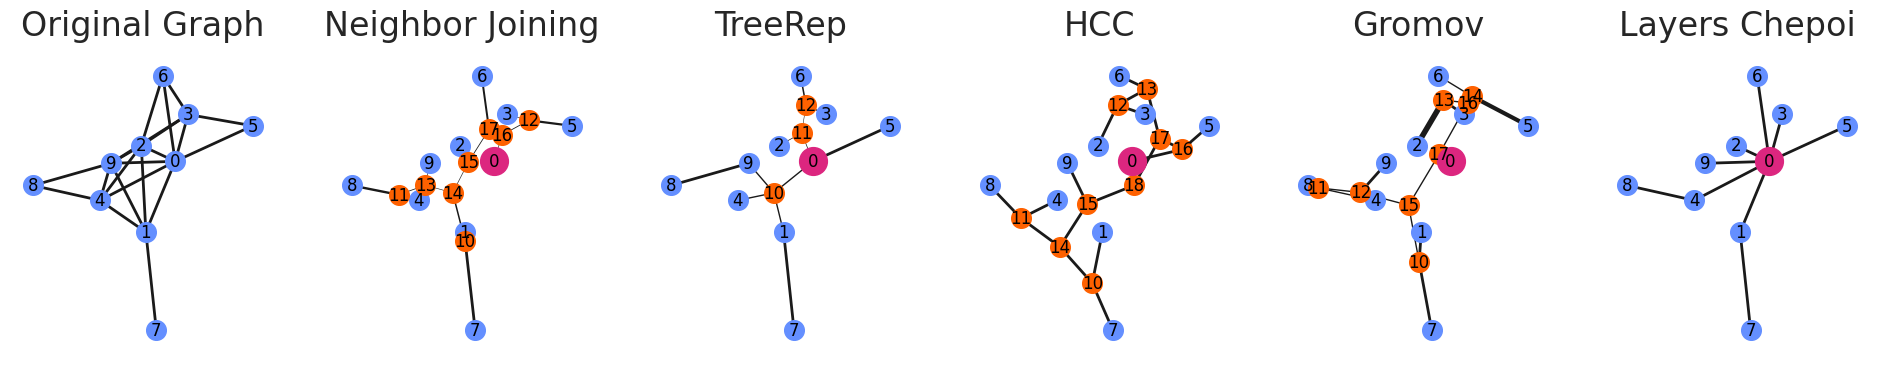

In [10]:
node_size=200
size_fig = 4
# let's plot the trees
fig, axes = plt.subplots(1, 6, figsize=(6*size_fig,size_fig))
#axes = axes.flatten()
# colorblind‑friendly
orig_color = '#648FFF'  # blue
int_color  = '#FE6100'  # orange
root_color = '#DC267F'  # colorblind-friendly green

# 1) Original points with labels
ax = axes[0]
fixed_positions = nx.spring_layout(random_graph, seed=0)
fixed_nodes = fixed_positions.keys()

draw_graph(N, distances, random_graph, ax, title='Original Graph', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
               node_size=node_size, show_root=False)

# 2) Neighbor‑Joining
ax = axes[1]
draw_graph(N, tree_nj_distances, tree_nj, ax, title='Neighbor Joining', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
               node_size=node_size, root=root)

# 3) TreeRep
ax = axes[2]

draw_graph(N, tree_TR_distances, tree_TR.G, ax, title='TreeRep', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
               node_size=node_size, root=root)

# 3) HCC
ax = axes[3]
draw_graph(N, tree_hcc_distance, tree_hcc.G, ax, title='HCC', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
               node_size=node_size, root=root)

# 4) Gromov
ax = axes[4]
draw_graph(N, distance_gromov_tree, tree_gromov_full, ax, title='Gromov', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
               node_size=node_size, root=root)

# 5) Chepoi
ax = axes[5]
draw_graph(N, distance_layering, layering_tree, ax, title='Layers Chepoi', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
               node_size=node_size, root=root)

plt.show()

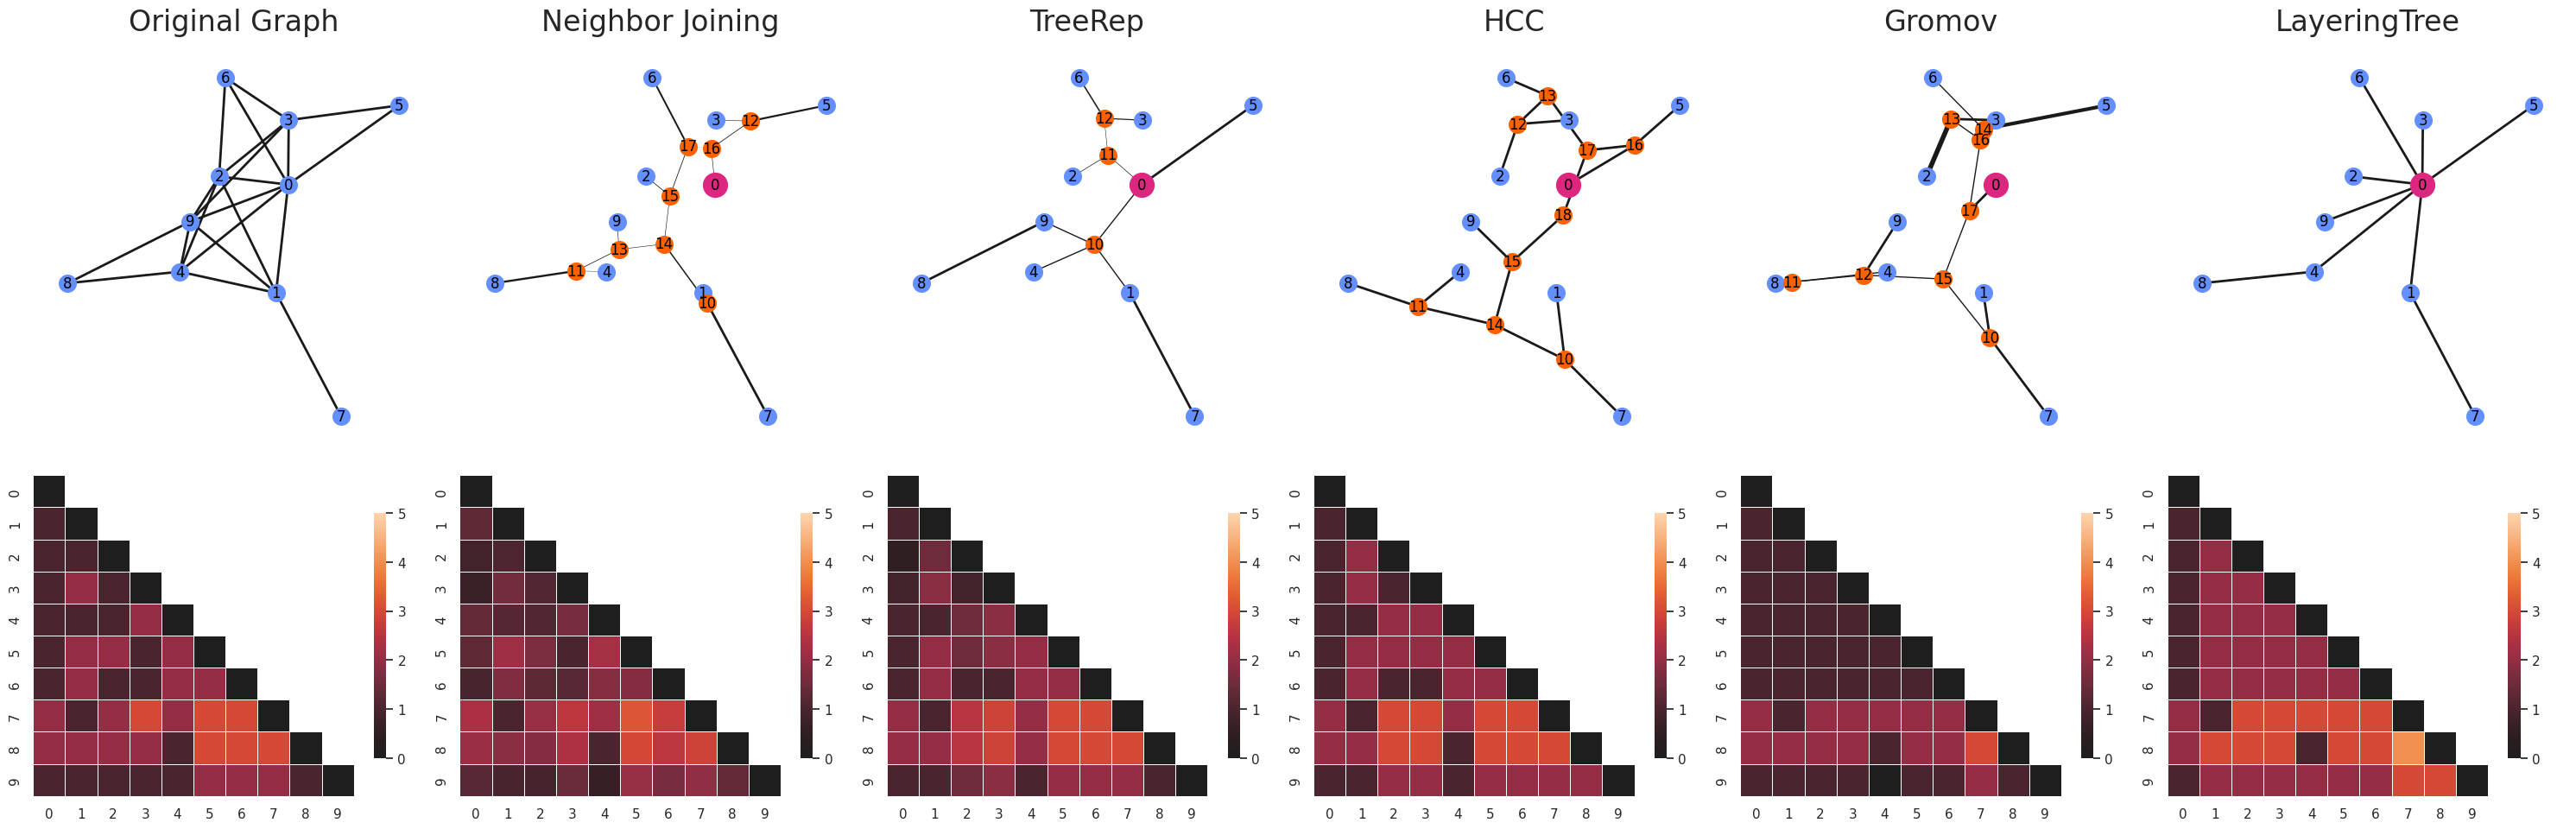

In [18]:
node_size=200
size_fig = 5
cmap_dist= sns.color_palette("icefire", as_cmap=True)
vmin=0
vmax=5

# let's plot the trees
fig, axes = plt.subplots(2, 6, figsize=(6*size_fig,2*size_fig))
#axes = axes.flatten()
# colorblind‑friendly
orig_color = '#648FFF'  # blue
int_color  = '#FE6100'  # orange
root_color = '#DC267F'  # colorblind-friendly green

# 1) Original points with labels
ax = axes[0,0]
fixed_positions = nx.spring_layout(random_graph, seed=0)
fixed_nodes = fixed_positions.keys()

draw_graph(N, distances, random_graph, ax, title='Original Graph', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
               node_size=node_size, show_root=False)

ax = axes[1,0]
plot_distances(distances, ax, vmin=vmin, vmax=vmax,cmap=cmap_dist)

# 2) Neighbor‑Joining
ax = axes[0,1]
draw_graph(N, tree_nj_distances, tree_nj, ax, title='Neighbor Joining', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
               node_size=node_size, root=root)
ax = axes[1,1]
plot_distances(tree_nj_distances[:10,:10], ax, vmin=vmin, vmax=vmax,cmap=cmap_dist)

# 3) TreeRep
ax = axes[0,2]

draw_graph(N, tree_TR_distances, tree_TR.G, ax, title='TreeRep', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
               node_size=node_size, root=root)
ax = axes[1,2]
plot_distances(tree_TR_distances[:10,:10], ax, vmin=vmin, vmax=vmax,cmap=cmap_dist)


# 3) HCC
ax = axes[0,3]
draw_graph(N, tree_hcc_distance, tree_hcc.G, ax, title='HCC', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
               node_size=node_size, root=root)
ax = axes[1,3]
l = np.argsort(tree_hcc.G.nodes)
plot_distances(tree_hcc.d_T, ax, vmin=vmin, vmax=vmax,cmap=cmap_dist)

# 4) Gromov
ax = axes[0,4]
draw_graph(N, distance_gromov_tree, tree_gromov_full, ax, title='Gromov', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
               node_size=node_size, root=root)
ax = axes[1,4]
l = np.argsort(tree_gromov_full.nodes)
plot_distances(distance_gromov_tree[l][:N,l[:N]], ax, vmin=vmin, vmax=vmax,cmap=cmap_dist)

# 5) Chepoi
ax = axes[0,5]
draw_graph(N, distance_layering, layering_tree, ax, title='LayeringTree', fixed_pos=fixed_positions, fixed_nodes=fixed_nodes,
               node_size=node_size, root=root)
ax = axes[1,5]
plot_distances(distance_layering[:10,:10], ax, vmin=vmin, vmax=vmax,cmap=cmap_dist)

plt.tight_layout()
plt.show()